# Plot ELG chains
This jupyter notebook contains some code to make plots of the bestfits and contours for the abacus cubic ELG fits to both the mock mean and individual realisations.

In [9]:
# Import some necessary modules
import os
import sys
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer     

sys.path.append("../../Barry/")     # Change this so that it points to where you have Barry installed

#from barry.samplers import DynestySampler
from barry.samplers import NautilusSampler
from barry.config import setup
from barry.models import PowerBeutler2017, CorrBeutler2017
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.fitter import Fitter
from barry.models.model import Correction # class for applying corrections to the likelihood function 
from barry.utils import weighted_avg_and_cov # function for getting avg and covariance 

#print(sys.path)
# Read in the fitter class to get all the info on the fit
#pfn = "../plots/desi_kp4_abacus_cubic_ELG/output/desi_kp4_abacus_cubic_ELG.fitter.pkl"

# omega_matter_free = False

# neff_free = True 

phase_shift_free = False #False 
wallisch18 = False
eh1998 = False
#CV = False  

pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG-c003/output/desi_kp4_abacus_cubic_ELG-c003.fitter.pkl"
pfn2 = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG-c003/output/"

# if omega_matter_free: 
#     pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_omfree/output/desi_kp4_abacus_cubic_ELG_omfree.fitter.pkl"

# if neff_free: 
#     pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_nefffree/output/desi_kp4_abacus_cubic_ELG_nefffree.fitter.pkl"
    
if phase_shift_free: 
    pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003.fitter.pkl"
    pfn2 = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003/output/"
    
    #pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-nosmoothFalse/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree-nosmoothFalse.fitter.pkl"
    #pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-limitkmin/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree-limitkmin.fitter.pkl"
    if wallisch18:
        pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003-Wallisch/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003-Wallisch.fitter.pkl"
        pfn2 = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003-Wallisch/output/"
        
    if eh1998:
        pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003-eh1998/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003-eh1998.fitter.pkl"
        pfn2 = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003-eh1998/output/"
        

with open(pfn, 'rb') as pickle_file:
    fitter = pickle.load(pickle_file)
    
    
# nosigma_s_incorr = False
#print(dir(fitter.sampler))

# sigma_s_mean = 0
# count = 0
# beta_mean = 0

This code segment reads in the chains, plots the bestfit model vs. data and prepares stuff for contour plots and summary files

In [10]:
logging.info("Creating plots")

fitname = []
#datanames = ["CV_Xi_Prerecon", "CV_Xi_Recon", "CV_Pk_Prerecon", "CV_Pk_Recon"]#, "Pk_Recon"]
datanames = ["Xi_Prerecon", "Xi_Recon", "Pk_Prerecon", "Pk_Recon"]#, "Pk_Recon"]

#datanames = ['Pk_Recon', 'Pk_Prerecon']

c = [ChainConsumer(), ChainConsumer(), ChainConsumer(), ChainConsumer()]

# Loop over all the chains
stats = {k: [] for k in datanames}
output = {k: [] for k in datanames}
for posterior, weight, chain, evidence, model, data, extra in fitter.load():

    #print(chain)
    #print(extra)
    #print(extra['name'])
    #print(model.get_labels(), chain.shape)
    # Get the realisation number and redshift bin
    #print(extra['name']) 
    
    #continue 
    #CVfile = ''
        
#     if CV:
#         CVfile = 'CV'
        
#     if not CV:
#         if "CV" in extra["name"]:
#            continue
#     else:
#         if "CV" not in extra['name']:
#             continue 
    
    
    if "Pk" not in extra["name"]:
       continue
            
#     #print(extra)
        
    recon_bin = 0 if "Prerecon" in extra["name"] else 1
    data_bin = 0 if "Xi" in extra["name"] else 1
    realisation = str(extra["name"].split()[-1]) if "realisation" in extra["name"] else "mean"
    chain_bin = int(2.0 * data_bin + recon_bin)
    print(extra["name"], chain_bin, realisation)
    #print(extra['name'])
    #print(model.get_labels(), chain.shape)
    # Store the chain in a dictionary with parameter names
    df = pd.DataFrame(chain, columns=model.get_labels())
    
    #cols = df.columns.to_numpy()
    #df = df.rename(columns={r'$\beta_{\\phi(N_{\mathrm{eff}})}$' : r'$\beta_{\phi(N_{\mathrm{eff}})}$'})

    # Compute alpha_par and alpha_perp for each point in the chain
    alpha_par, alpha_perp = model.get_alphas(df["$\\alpha$"].to_numpy(), df["$\\epsilon$"].to_numpy())
    df["$\\alpha_\\parallel$"] = alpha_par
    df["$\\alpha_\\perp$"] = alpha_perp
                                                        
    # Get the MAP (maximum a posteriori) point and set the model up at this point
    model.set_data(data)
    r_s = model.camb.get_data()["r_s"]
    max_post = posterior.argmax()
    params = df.loc[max_post]
    params_dict = model.get_param_dict(chain[max_post])
    #print(params_dict)
    for name, val in params_dict.items():
        model.set_default(name, val)

    # Get some useful properties of the fit, and plot the MAP model against the data if it's the mock mean or realisation 10 (chosen randomly!)
    display = True if realisation == "mean" or realisation == "10" else False
    #print(params_dict)
    new_chi_squared, dof, bband, mods, smooths = model.plot(params_dict, display=display)

    # Add the chain or MAP to the Chainconsumer plots
    extra.pop("realisation", None)
    if realisation == "mean":
        c[chain_bin].add_chain(df, weights=weight, **extra, plot_contour=True, plot_point=False, show_as_1d_prior=False)
    
        df_for_file = df
        df['weights'] = weight
        df_for_file.to_csv(pfn2 + extra['name'] +'.csv')
        
    else:
        c[chain_bin].add_marker(params, **extra, marker_size=80)

    # Compute some summary statistics and add them to a dictionary
    
    params = [
                "$\\alpha_\\parallel$",
                "$\\alpha_\\perp$",
                "$\\Sigma_{nl,||}$",
                "$\\Sigma_{nl,\\perp}$",
                "$\\Sigma_s$"
            ]
    
#     if '$\\Sigma_s$' not in cols:
#         params = [
#                 "$\\alpha_\\parallel$",
#                 "$\\alpha_\\perp$",
#                 "$\\Sigma_{nl,||}$",
#                 "$\\Sigma_{nl,\\perp}$",
#             ]
    
#     if omega_matter_free: 
#         params.append("$\\Omega_m$")
        
#     if neff_free:
#         params.append("$N_{\\mathrm{eff}}$")
        
    if phase_shift_free: 
        params.append("$\\beta_{\\phi(N_{\\mathrm{eff}})}$")
    
    mean, cov = weighted_avg_and_cov(
        df[
            params
        ],
        weight,
        axis=0,
    )
    
    #print(weighted_avg_and_cov(df["$\\beta$"], weight, axis=0)[0])
#     print(weighted_avg_and_cov(df["$\\alpha$"], weight, axis=0)[0])
#     print(weighted_avg_and_cov(df["$\\epsilon$"], weight, axis=0)[0])

#     if 'Prerecon' not in extra['name']:
#         sigma_s_mean += weighted_avg_and_cov(df["$\\Sigma_s$"], weight, axis=0)[0]
#         count += 1
        
#         beta_mean += weighted_avg_and_cov(df["$\\beta$"], weight, axis=0)[0]
    
#     print(mean)
    #continue
#     if omega_matter_free: ###################################
        
#         corr_alpha_para_perp = cov[1, 0] / np.sqrt(cov[0, 0] * cov[1, 1])
#         corr_alpha_para_phase = cov[5, 0] / np.sqrt(cov[5, 5] * cov[0, 0])
#         corr_alpha_perp_phase = cov[5, 1] / np.sqrt(cov[5, 5] * cov[1, 1])
        
#         if '$\\Sigma_s$' not in cols:
#             stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
#                 # mean omegam, stdev omegam, corrs omegam and alphas, chisquare, 
#                 # mean sigma_\\, mean sigma_perp
#                 [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
#                 corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3]]#, mean[4]]
#             )
#             output[datanames[chain_bin]].append(
#                 # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev omegam, corrs omegam/alphas .... other stats 
#                 f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
#             )
        
#         else:
#             stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
#                 # mean omegam, stdev omegam, corrs omegam and alphas, chisquare, 
#                 # mean sigma_\\, mean sigma_perp, mean sigma_s 
#                 [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
#                 corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3], mean[4]]
#             )

#             output[datanames[chain_bin]].append(
#                 # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev omegam, corrs omegam/alphas .... other stats 
#                 f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[4]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
#             )
        
#     elif neff_free: ###################################
        
#         corr_alpha_para_perp = cov[1, 0] / np.sqrt(cov[0, 0] * cov[1, 1])
#         corr_alpha_para_phase = cov[5, 0] / np.sqrt(cov[5, 5] * cov[0, 0])
#         corr_alpha_perp_phase = cov[5, 1] / np.sqrt(cov[5, 5] * cov[1, 1])
        
#         if '$\\Sigma_s$' not in cols:
#             stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
#                 # mean neff, stdev neff, corrs neff and alphas, chisquare, 
#                 # mean sigma_\\, mean sigma_perp 
#                 [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
#                 corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3]]#, mean[4]]
#             )
#             output[datanames[chain_bin]].append(
#                 # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev omegam, corrs omegam/alphas .... other stats 
#                 f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
#             )
#         else:
#             stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
#                 # mean neff, stdev neff, corrs neff and alphas, chisquare, 
#                 # mean sigma_\\, mean sigma_perp, mean sigma_s 
#                 [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
#                 corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3], mean[4]]
#             )
        
#         #print(len(stats[datanames[chain_bin]][-1]))

#             output[datanames[chain_bin]].append(
#                 # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev neff, corrs neff/alphas .... other stats 
#                 f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[4]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
#             )
        
    if phase_shift_free: ################################### 
        
        corr_alpha_para_perp = cov[1, 0] / np.sqrt(cov[0, 0] * cov[1, 1])
        corr_alpha_para_phase = cov[5, 0] / np.sqrt(cov[5, 5] * cov[0, 0])
        corr_alpha_perp_phase = cov[5, 1] / np.sqrt(cov[5, 5] * cov[1, 1])
        
        # if '$\\Sigma_s$' not in cols:
        #     stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
        #         # mean beta, stdev beta, corrs beta and alphas, chisquare, 
        #         # mean sigma_\\, mean sigma_perp, mean sigma_s 
        #         [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
        #         corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3]]#, mean[4]]
        #     )
        #     output[datanames[chain_bin]].append(
        #         # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev omegam, corrs omegam/alphas .... other stats 
        #         f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
        #     )
        # else:
        stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
            # mean beta, stdev beta, corrs beta and alphas, chisquare, 
            # mean sigma_\\, mean sigma_perp, mean sigma_s 
            [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
            corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3], mean[4]]
        )

        output[datanames[chain_bin]].append(
            # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev beta, corrs beta/alphas .... other stats 
            f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[4]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
        )
        
        
    else: ###################################
        
        corr = cov[1, 0] / np.sqrt(cov[0, 0] * cov[1, 1])
        
#         if '$\\Sigma_s$' not in cols:
#             stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, chisquare, 
#             # mean sigma_\\, mean sigma_perp
#             [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), corr, new_chi_squared, mean[2], mean[3]]#, mean[4]]
#             )
            
#             output[datanames[chain_bin]].append(
#             # realisation name, all means of params, stdevs on alphas .... other stats 
#             f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
#             )
#         else:
        stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, chisquare, 
            # mean sigma_\\, mean sigma_perp, mean sigma_s 
            [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), corr, new_chi_squared, mean[2], mean[3], mean[4]]
        )

        output[datanames[chain_bin]].append(
            # realisation name, all means of params, stdevs on alphas .... other stats 
            f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[4]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
        )
        #print('test')

DESI KP4 Abacus CubicBox Pk c003 gridc000 ELG Prerecon mock mean 2 mean


AttributeError: 'PowerBeutler2017' object has no attribute 'broadband_type'

Plot the contour plots and output the summary statistics

Pk_Prerecon


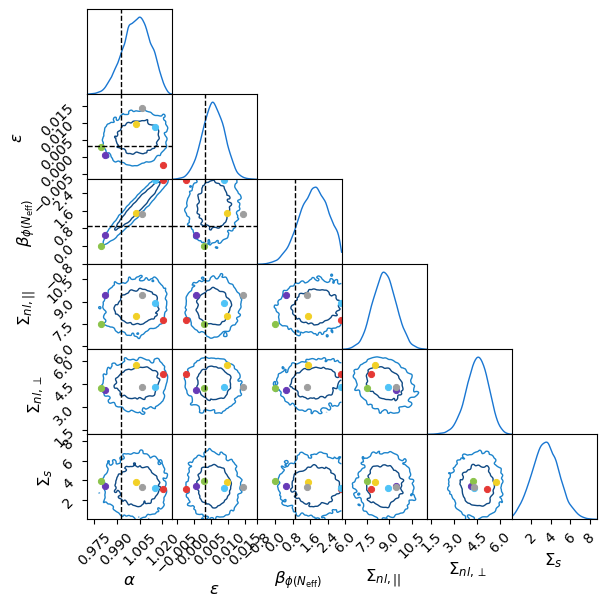

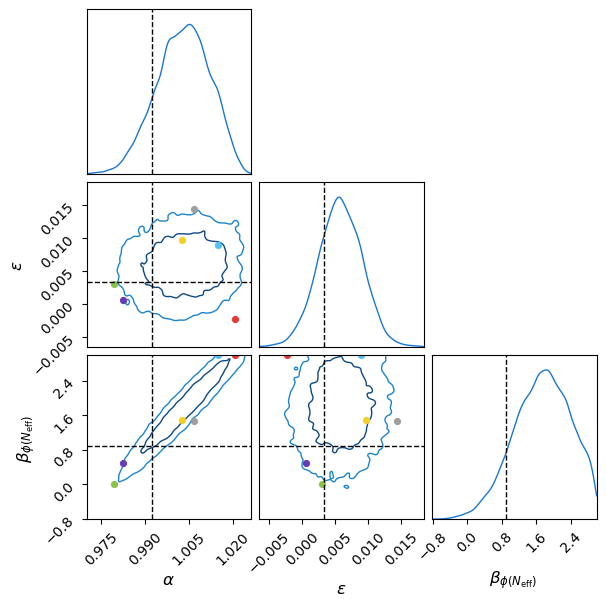

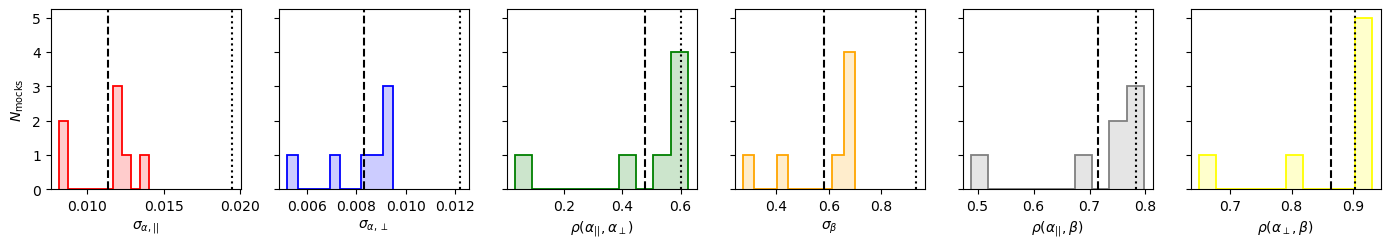

Pk_Recon


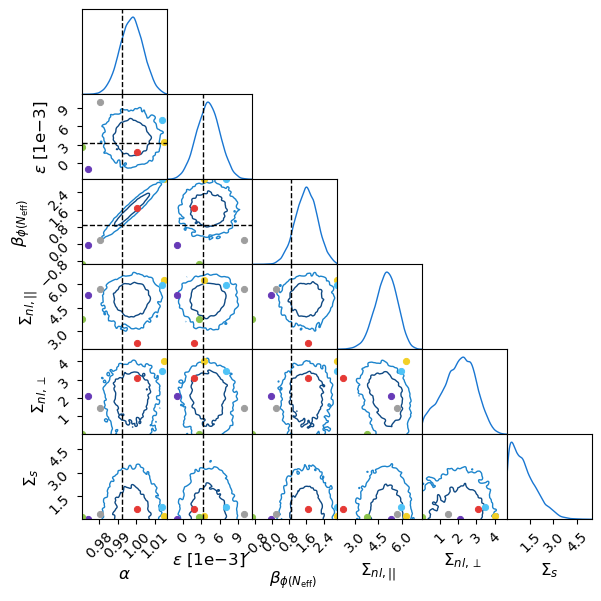

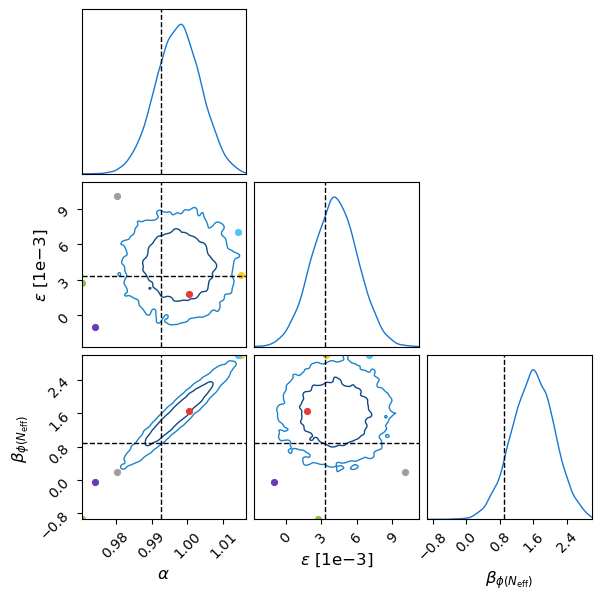

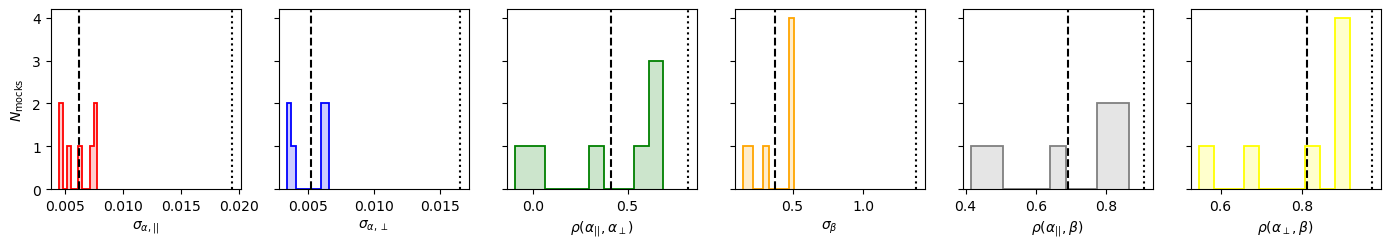

In [3]:
def plot_errors(stats, phase_shift_free=False, suffix=''):#omega_matter_free=False, neff_free=False, ):
    
    #print(stats)
    nstats = len(stats)
    means = np.mean(stats, axis=0)
    covs = np.cov(stats, rowvar=False)
    corr = covs[0, 1] / np.sqrt(covs[0, 0] * covs[1, 1])

    labels = [r"$\sigma_{\alpha,||}$", r"$\sigma_{\alpha,\perp}$", r"$\rho(\alpha_{||},\alpha_{\perp})$"] 
    colors = ["r", "b", "g"]
    
    #print(np.array(stats).T.shape)
    
#     if omega_matter_free:
#         labels.append(r"$\sigma_{\Omega_m}$")
#         labels.append(r"$\rho(\alpha_{||},\Omega_m)$")
#         labels.append(r"$\rho(\alpha_{\perp},\Omega_m)$")
#         colors.append("orange")
#         colors.append("grey")
#         colors.append("yellow")
        
#     if neff_free:
#         labels.append(r"$\sigma_{N_{\mathrm{eff}}}$")
#         labels.append(r"$\rho(\alpha_{||},N_{\mathrm{eff}})$")
#         labels.append(r"$\rho(\alpha_{\perp},N_{\mathrm{eff}})$")
#         colors.append("orange")
#         colors.append("grey")
#         colors.append("yellow")
        
    if phase_shift_free: 
        labels.append(r"$\sigma_{\beta}$")
        labels.append(r"$\rho(\alpha_{||},\beta)$")
        labels.append(r"$\rho(\alpha_{\perp},\beta)$")
        colors.append("orange")
        colors.append("grey")
        colors.append("yellow")

    fig, axes = plt.subplots(figsize=(7, 2), nrows=1, ncols=len(labels), sharey=True, squeeze=False)
    if phase_shift_free:#omega_matter_free or neff_free or 
        plt.subplots_adjust(left=0.1, top=0.95, bottom=0.05, right=2.0, hspace=0.3)
    else:
        plt.subplots_adjust(left=0.1, top=0.95, bottom=0.05, right=0.95, hspace=0.3)
    
    range_vals = [2,3,4]
    range_means = [2,3,4]
    stds_arr = [np.sqrt(covs[0, 0]), np.sqrt(covs[1, 1]), corr]
    
    if phase_shift_free: #omega_matter_free or neff_free or 
        range_vals = [2,3,4,6,7,8] 
        stds_arr = [
                   np.sqrt(covs[0, 0]), 
                   np.sqrt(covs[1, 1]), 
                   corr,
                   np.sqrt(covs[5, 5]),
                   covs[0, 5] / np.sqrt(covs[0, 0] * covs[5, 5]),
                   covs[5, 1] / np.sqrt(covs[5, 5] * covs[1, 1])
                   ]
        range_means = [2,3,4,6,7,8] 
    
    for ax, vals, avgs, stds, l, c in zip(axes.T, np.array(stats).T[range_vals,:], means[range_means], stds_arr, labels, colors):

        ax[0].hist(vals, 10, color=c, histtype="stepfilled", alpha=0.2, density=False, zorder=0)
        ax[0].hist(vals, 10, color=c, histtype="step", alpha=1.0, lw=1.3, density=False, zorder=1)
        ax[0].axvline(avgs, color="k", ls="--", zorder=2)
        ax[0].axvline(stds, color="k", ls=":", zorder=2)
        ax[0].set_xlabel(l)
        
    axes[0, 0].set_ylabel(r"$N_{\mathrm{mocks}}$")

    #plt.savefig("plots/desi_kp4_abacus_cubic_ELG"+suffix+"/output/histplot_v2.png", bbox_inches='tight')
    plt.show()

    return nstats, means, covs, corr

couplingterm = 1.0/0.22710731766023898
beta_approx = (3.044/(3.044+couplingterm) * (3.7+couplingterm)/3.7) 

alpha, eps = model.get_reverse_alphas(0.99906947, 0.98927880)

truth = {"$\\alpha$": alpha, "$\\epsilon$": eps, "$\\alpha_\\parallel$": 0.99906947, "$\\alpha_\\perp$": 0.98927880}#, 
         #"$\\beta_{\\phi(N_{\\mathrm{eff}})}$": beta_approx}

#truth = {"$\\alpha$": 1.0, "$\\epsilon$": 0, "$\\alpha_\\perp$": 1.0, "$\\alpha_\\parallel$": 1.0}
#truth = {"$\\alpha$": 1.0, "$\\epsilon$": 0, "$\\alpha_\\perp$": 1.0, "$\\alpha_\\parallel$": 1.0}

# if omega_matter_free: 
#     truth["$\\Omega_m$"] = 0.31
# if neff_free:
#     truth["$N_{\mathrm{eff}}$"] = 3.044
if phase_shift_free:
    truth["$\\beta_{\\phi(N_{\\mathrm{eff}})}$"] = beta_approx#1.0

parameters = [names for names in truth]
parameters.append("$\\Sigma_{nl,||}$")
parameters.append("$\\Sigma_{nl,\\perp}$")
parameters.append("$\\Sigma_s$")

suffix = ''

# if omega_matter_free: 
#     suffix = '_omfree'
# elif neff_free:
#     suffix = '_nefffree'
if phase_shift_free:
    suffix = '_phaseshiftfree'

for chain_bin in range(len(c)):
    
    # for i in stats[datanames[chain_bin]]:
    #     print(len(i))
    # #if datanames[chain_bin] != 'CV_Pk_Recon':
    #    continue 
        
    if 'Pk' not in datanames[chain_bin]:
        continue 
    
        
    print(datanames[chain_bin])
    
    parameters_used = parameters 
    
    # if nosigma_s_incorr and 'Pk' not in datanames[chain_bin]:
    #     parameters_used = parameters[0:-1]

    c[chain_bin].plotter.plot(
    truth=truth,
        parameters=(parameters_used[:2]+parameters_used[4:]),
        #parameters =parameters[2:],
        legend=False,
        display=True,
        figsize=(6,6), 
        #filename="plots/desi_kp4_abacus_cubic_ELG" + suffix + "/output/contourplot_v2" + CVfile + ".png",
        
    )
    
    if phase_shift_free:# omega_matter_free or neff_free or  
        c[chain_bin].plotter.plot(
        truth=truth,
            parameters=(parameters_used[:2]+[parameters_used[4]]),
            #parameters =parameters[2:],
            legend=False,
            display=True,
            figsize=(6,6), 
            #filename="plots/desi_kp4_abacus_cubic_ELG" + suffix + "/output/contourplot_v2" + CVfile + ".png",

        )
    else:
        c[chain_bin].plotter.plot(
        truth=truth,
            #parameters=(parameters_used[:2]),
            parameters =parameters[:2],
            legend=False,
            display=True,
            figsize=(6,6), 
            #filename="plots/desi_kp4_abacus_cubic_ELG" + suffix + "/output/contourplot_v2" + CVfile + ".png",

        )
    #continue 
    # Plot histograms of the errors and r_off
    nstats, means, covs, corr = plot_errors(stats[datanames[chain_bin]],
                                            #omega_matter_free=omega_matter_free,
                                            #neff_free=neff_free,
                                            phase_shift_free=phase_shift_free,
                                            suffix=suffix)
    
    #continue 
    #continue 
    # Save all the numbers to a file
#     if omega_matter_free:###################################
        
#         with open("plots/desi_kp4_abacus_cubic_ELG_omfree/output/Barry_fit_" + CVfile + datanames[chain_bin] + ".txt", "w") as f:
            
#             if nosigma_s_incorr and 'Pk' not in datanames[chain_bin]:
#                 f.write(
#                     "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Omegam, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_Omegam, corr_Omegam_alpha_par, corr_Omegam_alpha_prep, rd_of_template, bf_chi2, dof\n"
#                     )
                
#             else:
#                 f.write(
#                     "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Sigma_s, Omegam, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_Omegam, corr_Omegam_alpha_par, corr_Omegam_alpha_prep, rd_of_template, bf_chi2, dof\n"
#                     ) 

#             for l in output[datanames[chain_bin]]:
#                 f.write(l + "\n")

#             # And now the average of all the individual realisations
#             f.write("# ---------------------------------------------------\n")
#             f.write(
#                 "# <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <omega_m>, <sigma_alpha_par>, <sigma_alpha_perp>, <sigma_omega_m>, <corr_alpha_par_perp>, <corr_alpha_par_m>, <corr_alpha_perp_m>, std_alpha_par, std_alpha_perp, std_omegam, corr_alpha_par_perp, corr_alpha_par_omegam, corr_alpha_perp_omegam, <bf_chi2>\n"
#                 )
#             f.write(
#                 f"{means[0]:6.4f}, {means[1]:6.4f}, {means[10]:6.4f}, {means[11]:6.4f}, {means[5]:6.4f}, {means[2]:6.4f}, {means[3]:6.4f}, {means[6]:6.4f}, {means[4]:6.4f}, {means[7]:6.4f}, {means[8]:6.4f}, {np.sqrt(covs[0, 0]):6.4f}, {np.sqrt(covs[1, 1]):6.4f}, {np.sqrt(covs[5, 5]):6.4f}, {corr:6.4f}, {(covs[0, 5] / np.sqrt(covs[0, 0] * covs[5, 5])):6.4f},{(covs[5, 1] / np.sqrt(covs[5, 5] * covs[1, 1])):6.4f}, {means[9]:7.3f}\n"
#                 )
            
            
#     elif neff_free:###################################
        
#         # print('check')
#         with open("plots/desi_kp4_abacus_cubic_ELG_nefffree/output/Barry_fit_" + CVfile + datanames[chain_bin] + ".txt", "w") as f:
            
#             if nosigma_s_incorr and 'Pk' not in datanames[chain_bin]: 
#                 f.write(
#                     "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Neff, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_Neff, corr_Neff_alpha_par, corr_Neff_alpha_prep, rd_of_template, bf_chi2, dof\n"
#                     )
            
#             else: 
#                 f.write(
#                 "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Sigma_s, Neff, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_Neff, corr_Neff_alpha_par, corr_Neff_alpha_prep, rd_of_template, bf_chi2, dof\n"
#                 )
            
#             for l in output[datanames[chain_bin]]:
#                 f.write(l + "\n")

#             # And now the average of all the individual realisations
#             f.write("# ---------------------------------------------------\n")
#             f.write(
#                 "# <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <neff>, <sigma_alpha_par>, <sigma_alpha_perp>, <sigma_neff>, <corr_alpha_par_perp>, <corr_alpha_par_neff>, <corr_alpha_perp_neff>, std_alpha_par, std_alpha_perp, std_neff, corr_alpha_par_perp, corr_alpha_par_neff, corr_alpha_perp_neff, <bf_chi2>\n"
#                 )
#             f.write(
#                 f"{means[0]:6.4f}, {means[1]:6.4f}, {means[10]:6.4f}, {means[11]:6.4f}, {means[5]:6.4f}, {means[2]:6.4f}, {means[3]:6.4f}, {means[6]:6.4f}, {means[4]:6.4f}, {means[7]:6.4f}, {means[8]:6.4f}, {np.sqrt(covs[0, 0]):6.4f}, {np.sqrt(covs[1, 1]):6.4f}, {np.sqrt(covs[5, 5]):6.4f}, {corr:6.4f}, {(covs[0, 5] / np.sqrt(covs[0, 0] * covs[5, 5])):6.4f},{(covs[5, 1] / np.sqrt(covs[5, 5] * covs[1, 1])):6.4f}, {means[9]:7.3f}\n"
#                 )
            
    if phase_shift_free: ###################################
        
        filepath = "plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003/output/Barry_fit_"
        #pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-nosmoothFalse/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree-nosmoothFalse.fitter.pkl"
        #pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-limitkmin/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree-limitkmin.fitter.pkl"
        if wallisch18:
            filepath = "plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003-Wallisch/output/Barry_fit_"
            
        if eh1998:
                filepath = "plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-c003-eh1998/output/Barry_fit_"

        
        #print(datanames[chain_bin])
        # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
            # mean beta, stdev beta, corrs beta and alphas, chisquare, 
            # mean sigma_\\, mean sigma_perp, mean sigma_s 
        with open(filepath + datanames[chain_bin] + ".txt", "w") as f:
            
            # if nosigma_s_incorr and 'Pk' not in datanames[chain_bin]: 
            #     f.write(
            #         "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, beta, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_beta, corr_beta_alpha_par, corr_beta_alpha_prep, rd_of_template, bf_chi2, dof\n"
            #         )
            # else: 
            f.write(
                "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Sigma_s, beta, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_beta, corr_beta_alpha_par, corr_beta_alpha_prep, rd_of_template, bf_chi2, dof\n"
                )
                
            for l in output[datanames[chain_bin]]:
                f.write(l + "\n")

            # And now the average of all the individual realisations
            f.write("# ---------------------------------------------------\n")
            f.write(
                "# <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <phi>, <sigma_alpha_par>, <sigma_alpha_perp>, <sigma_phi>, <corr_alpha_par_perp>, <corr_alpha_par_phi>, <corr_alpha_perp_phi>, std_alpha_par, std_alpha_perp, std_phi, corr_alpha_par_perp, corr_alpha_par_phi, corr_alpha_perp_phi, <bf_chi2>\n"
                )
            f.write(
                f"{means[0]:6.4f}, {means[1]:6.4f}, {means[10]:6.4f}, {means[11]:6.4f}, {means[5]:6.4f}, {means[2]:6.4f}, {means[3]:6.4f}, {means[6]:6.4f}, {means[4]:6.4f}, {means[7]:6.4f}, {means[8]:6.4f}, {np.sqrt(covs[0, 0]):6.4f}, {np.sqrt(covs[1, 1]):6.4f}, {np.sqrt(covs[5, 5]):6.4f}, {corr:6.4f}, {(covs[0, 5] / np.sqrt(covs[0, 0] * covs[5, 5])):6.4f},{(covs[5, 1] / np.sqrt(covs[5, 5] * covs[1, 1])):6.4f}, {means[9]:7.3f}\n"
                )
        
    else:###################################
            
        with open("plots/desi_kp4_abacus_cubic_ELG-c003/output/Barry_fit_" + datanames[chain_bin] + ".txt", "w") as f:
            
            # if nosigma_s_incorr and 'Pk' not in datanames[chain_bin]:
            #     f.write(# realisation name, all means of params, stdevs on alphas .... other stats 
            #         "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Sigma_s, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, rd_of_template, bf_chi2, dof\n"
            #         )
            # else:
            f.write(# realisation name, all means of params, stdevs on alphas .... other stats 
                "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, rd_of_template, bf_chi2, dof\n"
                )
            
            for l in output[datanames[chain_bin]]:
                f.write(l + "\n")

            # And now the average of all the individual realisations
            f.write("# ---------------------------------------------------\n")
            f.write(
                "# <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <sigma_alpha_par>, <sigma_alpha_perp>, <corr_alpha_par_perp>, std_alpha_par, std_alpha_perp, corr_alpha_par_perp, <bf_chi2>\n"
                )
            f.write(
                f"{means[0]:6.4f}, {means[1]:6.4f}, {means[6]:6.4f}, {means[7]:6.4f}, {means[2]:6.4f}, {means[3]:6.4f}, {means[4]:6.4f}, {np.sqrt(covs[0, 0]):6.4f}, {np.sqrt(covs[1, 1]):6.4f}, {corr:6.4f}, {means[5]:7.3f}\n"
                )
        
        